# Приложение по доставке еды

Было проведено 2 А/Б теста:
- В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные. Причем:
    - A – прямоугольные 16:9
    - B – квадратные
    - C – прямоугольные 12:4
- Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый. 
### Задача : проверить было ли в этих эспериментах различие между группами.

In [1]:
# испорт библиотек

import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [2]:
# подгрузка данных с первого эксперимента

task_1 = pd.read_csv('5_task_1.csv')
task_1

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38
...,...,...,...
29995,22932,C,38
29996,21787,C,25
29997,5054,C,34
29998,10254,C,27


In [3]:
# выделение массивов данных отдельных групп

A_group = task_1[task_1.group == 'A'].events
B_group = task_1[task_1.group == 'B'].events
C_group = task_1[task_1.group == 'C'].events 

### Для сравнения средних в первом тесте будет использоваться ANOVA

1. С помощью теста Левина проверяем гомогенность дисперсий внутри групп

In [4]:
stats.levene(A_group, B_group, C_group) 

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

p-value > 0,05 значит дисперсии внутри групп гомогенны

2. Убедимся, что данные имеют нормальные распределения, для этого применим тест Шапиро- Уилка, НО так как на больших выборках он детектирует даже самые незначительные отклонения от нормальности, возьмем случайные 1000 значений из выборки, чтобы обойти этот недостаток. НО шанс что выборка из 1000 значений имеет ненормальное распределение есть, поэтому используем аргумент random_state=17: для стабильности и воспроизводимости результатов.

In [5]:
A_group_sample = A_group.sample(1000, random_state=17)
B_group_sample = B_group.sample(1000, random_state=17)
C_group_sample = C_group.sample(1000, random_state=17) 

In [6]:
stats.shapiro(A_group_sample)

ShapiroResult(statistic=0.9973153471946716, pvalue=0.09609563648700714)

In [7]:
stats.shapiro(B_group_sample)

ShapiroResult(statistic=0.9980798363685608, pvalue=0.31768906116485596)

In [8]:
stats.shapiro(C_group_sample)

ShapiroResult(statistic=0.9981185793876648, pvalue=0.3359004259109497)

p-value > 0,05 значит распределения нормальны 

3. Проводим однофакторный дисперсионный анализ 

In [9]:
stats.f_oneway(A_group, B_group, C_group) 

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

p-value < 0,05 значит статистически значимые различия хотя бы между двух из групп есть 

4. Используем критерий Тьюки для выявления различий между конкретными группами

In [10]:
MultiComp = MultiComparison(task_1.events, task_1.group)

MultiComp.tukeyhsd().summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.001,7.7038,8.3642,True
A,C,-2.1093,0.001,-2.4395,-1.7791,True
B,C,-10.1433,0.001,-10.4735,-9.8131,True


Колонка reject показывает, что есть статистически значимые различия между средними трех групп

In [11]:
A_group.mean() , B_group.mean() , C_group.mean()

(29.5796, 37.6136, 27.4703)

# Вывод : 
- На основании анализа можем сделать вывод, что лучше всего использовать группу B- квадратные картинки.

In [12]:
# подгрузка данных со вторым тестом
task_2 = pd.read_csv('5_task_2.csv')
task_2

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0
...,...,...,...,...
99995,60695,control,low,15.0
99996,5934,control,low,16.0
99997,30046,control,low,22.0
99998,26474,control,low,21.0


In [13]:
# выделяем массивы с данными разных групп 
test_group = task_2[task_2.group == 'test'].events
control_group = task_2[task_2.group == 'control'].events

### Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента, следовательно будет использоваться многофакторный дисперсионный анализ

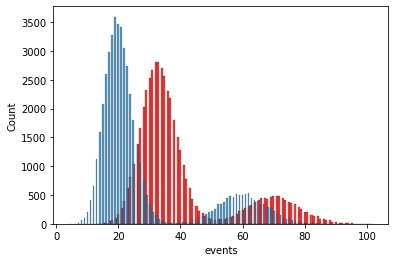

In [14]:
# график распределения events в зависимости от группы
sns.histplot(test_group, color = 'red')
sns.histplot(control_group)

In [15]:
# посчитаем среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя. 
task_2.groupby(['group', 'segment']).events.describe()

count       mean       std   min   25%   50%   75%    max
group   segment                                                             
control high     10000.0  59.970800  7.805347  31.0  55.0  60.0  65.0   89.0
        low      40000.0  20.031575  4.473576   4.0  17.0  20.0  23.0   41.0
test    high     10000.0  69.938500  8.403974  40.0  64.0  70.0  76.0  102.0
        low      40000.0  33.025925  5.720845  13.0  29.0  33.0  37.0   59.0

In [21]:
# определим формулу для многофакторного дисперсионного анализа
formula = 'events ~ segment + group + segment:group'
model = ols(formula, task_2).fit()
aov_table = anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
segment,2.362480e+07,1.0,689756.377484,0.000000e+00
group,3.837195e+06,1.0,112031.864119,0.000000e+00
segment:group,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


In [17]:
task_2['combination'] = task_2['group'] + ' \\ ' + task_2['segment']

In [18]:
task_2

,id,group,segment,events,combination
0,83440,test,high,78.0,test \ high
1,96723,test,high,71.0,test \ high
2,68719,test,high,80.0,test \ high
3,50399,test,high,80.0,test \ high
4,95613,test,high,78.0,test \ high
...,...,...,...,...,...
99995,60695,control,low,15.0,control \ low
99996,5934,control,low,16.0,control \ low
99997,30046,control,low,22.0,control \ low
99998,26474,control,low,21.0,control \ low


Используем критерий Тьюки, чтобы понять между какими группами есть статистически значимые различия

In [19]:
pairwise_tukeyhsd(task_2.events, task_2.combination).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control \ high,control \ low,-39.9392,0.001,-40.1073,-39.7711,True
control \ high,test \ high,9.9677,0.001,9.7551,10.1803,True
control \ high,test \ low,-26.9449,0.001,-27.113,-26.7768,True
control \ low,test \ high,49.9069,0.001,49.7388,50.075,True
control \ low,test \ low,12.9944,0.001,12.888,13.1007,True
test \ high,test \ low,-36.9126,0.001,-37.0807,-36.7445,True


Выводы:
- Для обоих сегментов показатели статистически значимо увеличились по сравнению с контрольной группой
- Разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 13
- Разница между control/high и test/high составила около 10

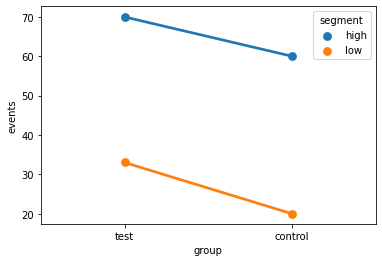

In [20]:
# визуализируем результаты теста
sns.pointplot(x="group", y="events", data=task_2, hue = 'segment')

## Вывод:
Фактор group и фактор segment и их взаимодействие оказались значимыми. Судя по графику, для всех групп среднее значение events увеличилось. Поэтому решение: выкатываем новую версию кнопки.